<p>Topic: Yoga poses detection</p>
<p>Pre-trainned models used: MobilenetV2 and VGG16</p>

In [1]:
#imports
from keras.applications import VGG16
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import imutils
from google.colab.patches import cv2_imshow

<p>Preparing custom dataset. Annotation has been done using makesense.ai.</p>

In [4]:
#fetching paths of dataset and annotation
current_path = os.getcwd()
current_path = current_path+'/Yoga_Dataset'
print(current_path)
images = current_path+'/Dataset'
annotations = current_path+'/Annoations.csv'
print(images)
print(annotations)


/content/drive/MyDrive/Yoga_Dataset
/content/drive/MyDrive/Yoga_Dataset/Dataset
/content/drive/MyDrive/Yoga_Dataset/Annoations.csv


In [5]:
!unzip -q ./Yoga_Dataset.zip -d ./Yoga_Dataset

replace ./Yoga_Dataset/Annoations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
df = pd.read_csv(annotations)
df.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,bow,152,375,354,292,1.jpg,696,696
1,bow,397,206,1031,748,10.jpg,1600,1156
2,goddess,200,41,194,291,100.jpg,580,370
3,goddess,247,95,287,321,101.jpg,730,487
4,goddess,97,38,1119,1531,102.png,1281,1732


In [7]:
#one hot encoding
labelsAndCategories = {
    0: 'bow',
    1: 'corpse',
    2: 'downdog',
    3: 'goddess',
    4: 'boat',
    5: 'lotus',
    6: 'monkey',
    7: 'plank',
    8: 'tree',
    9: 'warrior'
}

encodedCategories={}

for i, j in labelsAndCategories.items():
  temp = [1 if k==i else 0 for k in range(10)] 
  encodedCategories[j] = temp
print(encodedCategories)


{'bow': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'corpse': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'downdog': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 'goddess': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'boat': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'lotus': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'monkey': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 'plank': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'tree': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'warrior': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}


In [8]:
#creating separate arrays for images, bounding box dimensions and categories for further use
imageInfo = ['label_name','bbox_x','bbox_y','bbox_width','bbox_height','image_name']
allImages=[]
boundingBox=[]
labels=[]

for i, j in df.iterrows():
  #loop over complete csv file and fetch image details
  for k in range(len(imageInfo)):
    imageInfo[k]=j[k]
  # print(imageInfo)
  #derive image path and fetch its dimensions
  imagePath=images+'/'+imageInfo[5]
  image=cv2.imread(imagePath)
  imageHeight=image.shape[0]
  imageWidht=image.shape[1]
  
  #scaling the bounding box coordinates relative to the spatial dimensions of the input image
  xCord = float(imageInfo[1]) / imageWidht
  yCord = float(imageInfo[2]) / imageHeight
  height = float(imageInfo[4]) / imageWidht
  width = float(imageInfo[3]) / imageHeight

  #load image and assign default target size
  image=load_img(imagePath,target_size=(224,224))
  image=img_to_array(image)

  #final arrays with images, bounding box dimensions and categories
  allImages.append(image)
  boundingBox.append((xCord,yCord,width,height))
  labels.append(encodedCategories[imageInfo[0]])
  

In [9]:
#Normalization
allImages=np.array(allImages,dtype='float32') / 255.0
boundingBox=np.array(boundingBox,dtype='float32')
labels = np.array(labels)

In [10]:
#Splitting data into test and train
split = train_test_split(allImages, labels, boundingBox, test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBoundingBox, testBoundingBox) = split[4:]

<p>Model preparation using pre trained model: MobileNetV2</p>

In [11]:
# load the mobileNetV2 network
mobileNetV2 = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',input_shape=(224,224,3))

# freeze all mobileNetV2 layers so they will *not* be updated during the training process
mobileNetV2.trainable = False

# flatten the max-pooling output of mobileNetV2
flatten = mobileNetV2.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted bounding box coordinates
layer_1 = Dense(128, activation="relu")(flatten)
layer_1 = Dense(64, activation="relu")(layer_1)
layer_1 = Dense(32, activation="relu")(layer_1)
layer_1 = Dense(4, activation="sigmoid", name="bounding_box")(layer_1)

# construct a fully-connected layer header to output the predicted categories
layer_2 = Dense(512, activation="relu")(flatten)
layer_2 = Dropout(0.5)(layer_2)
layer_2 = Dense(128, activation="relu")(layer_2)
layer_2 = Dropout(0.5)(layer_2)
layer_2 = Dense(10, activation="softmax", name="class_label")(layer_2)

#creating model which takes input image and output bounding box coordinates and categories
mobileNetV2 = Model(mobileNetV2.input, [layer_2, layer_1])
mobileNetV2.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [12]:
mobileNetV2.compile(
    optimizer=Adam(0.00001, clipvalue=100), 
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[1,10],metrics=['accuracy']
)

history_mobileNetV2 = mobileNetV2.fit(trainImages, [trainLabels, trainBoundingBox],
                    validation_data = (testImages, [testLabels, testBoundingBox]),
                    batch_size = 32,
                    epochs =100,
                    verbose = 1)

Epoch 1/100
9/9 [==============================] - 12s 240ms/step - loss: 6.1771 - class_label_loss: 4.8698 - bounding_box_loss: 0.1307 - class_label_accuracy: 0.0895 - bounding_box_accuracy: 0.4786 - val_loss: 3.2291 - val_class_label_loss: 2.4705 - val_bounding_box_loss: 0.0759 - val_class_label_accuracy: 0.1846 - val_bounding_box_accuracy: 0.7077
Epoch 2/100
9/9 [==============================] - 1s 70ms/step - loss: 3.8096 - class_label_loss: 3.1211 - bounding_box_loss: 0.0689 - class_label_accuracy: 0.1907 - bounding_box_accuracy: 0.7782 - val_loss: 2.7567 - val_class_label_loss: 2.1341 - val_bounding_box_loss: 0.0623 - val_class_label_accuracy: 0.2308 - val_bounding_box_accuracy: 0.7692
Epoch 3/100
9/9 [==============================] - 1s 68ms/step - loss: 3.2784 - class_label_loss: 2.7040 - bounding_box_loss: 0.0574 - class_label_accuracy: 0.2451 - bounding_box_accuracy: 0.8132 - val_loss: 2.5166 - val_class_label_loss: 1.9441 - val_bounding_box_loss: 0.0573 - val_class_label_a

In [13]:
mobileNetV2.evaluate(testImages, [testLabels, testBoundingBox], batch_size=32)

3/3 [==============================] - 0s 36ms/step - loss: 1.1057 - class_label_loss: 0.7628 - bounding_box_loss: 0.0343 - class_label_accuracy: 0.7846 - bounding_box_accuracy: 0.8923


[1.1057220697402954,
 0.7627621293067932,
 0.03429599106311798,
 0.7846153974533081,
 0.892307698726654]

In [14]:
h5File_mobileNetV2 = current_path+'/mobileNetV2.h5'
mobileNetV2.save(h5File_mobileNetV2)
mobileNetV2.load_weights(h5File_mobileNetV2)

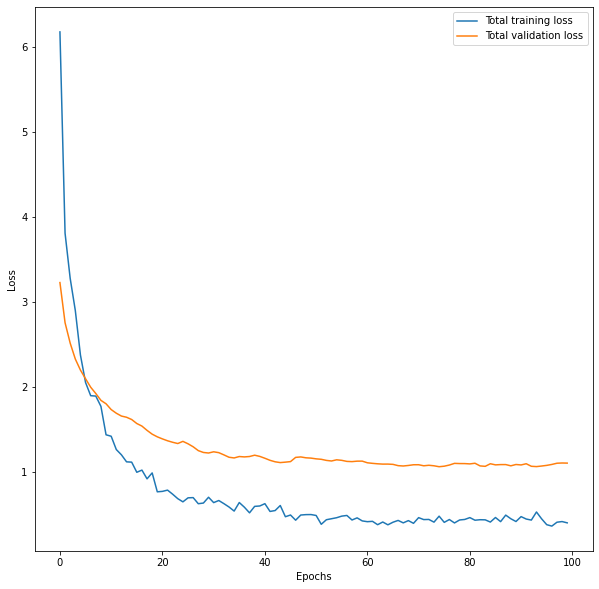

In [15]:
plt.figure(figsize=(10, 10))

plt.plot(history_mobileNetV2.history['loss'], label='Total training loss')
plt.plot(history_mobileNetV2.history['val_loss'], label='Total validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

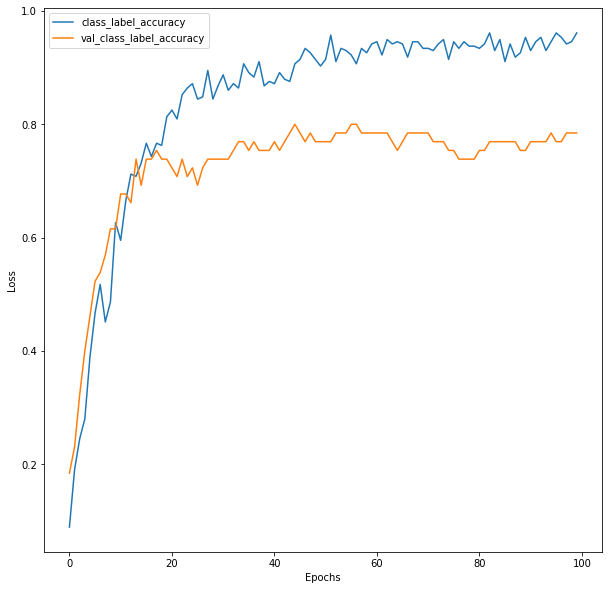

In [16]:
plt.figure(figsize=(10, 10))

plt.plot(history_mobileNetV2.history['class_label_accuracy'], label='class_label_accuracy')
plt.plot(history_mobileNetV2.history['val_class_label_accuracy'], label='val_class_label_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<p>Model preparation using pre trained model: VGG16</p>

In [17]:
# load the vgg16 network
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))

# freeze all vgg16 layers so they will *not* be updated during the training process
vgg16.trainable = False

# flatten the max-pooling output of vgg16
flatten = vgg16.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted bounding box coordinates
layer_vgg16_1 = Dense(128, activation="relu")(flatten)
layer_vgg16_1 = Dense(64, activation="relu")(layer_vgg16_1)
layer_vgg16_1 = Dense(32, activation="relu")(layer_vgg16_1)
layer_vgg16_1 = Dense(4, activation="sigmoid", name="bounding_box")(layer_vgg16_1)

# construct a fully-connected layer header to output the predicted categories
layer_vgg16_2 = Dense(512, activation="relu")(flatten)
layer_vgg16_2 = Dropout(0.5)(layer_vgg16_2)
layer_vgg16_2 = Dense(10, activation="softmax", name="class_label")(layer_vgg16_2)

#creating model which takes input image and output bounding box coordinates and categories
vgg16 = Model(vgg16.input, [layer_vgg16_2, layer_vgg16_1])
vgg16.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                           

In [18]:
vgg16.compile(
    optimizer=Adam(0.00001, clipvalue=100), 
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[1,10],metrics=['accuracy']
)

history_vgg16 = vgg16.fit(trainImages, [trainLabels, trainBoundingBox],
                    validation_data = (testImages, [testLabels, testBoundingBox]),
                    batch_size = 32,
                    epochs =100,
                    verbose = 1)

Epoch 1/100
9/9 [==============================] - 6s 299ms/step - loss: 4.0927 - class_label_loss: 2.6039 - bounding_box_loss: 0.1489 - class_label_accuracy: 0.0973 - bounding_box_accuracy: 0.4708 - val_loss: 3.2565 - val_class_label_loss: 2.1347 - val_bounding_box_loss: 0.1122 - val_class_label_accuracy: 0.3077 - val_bounding_box_accuracy: 0.7846
Epoch 2/100
9/9 [==============================] - 2s 178ms/step - loss: 3.4181 - class_label_loss: 2.3655 - bounding_box_loss: 0.1053 - class_label_accuracy: 0.1868 - bounding_box_accuracy: 0.7626 - val_loss: 2.8850 - val_class_label_loss: 2.0319 - val_bounding_box_loss: 0.0853 - val_class_label_accuracy: 0.3846 - val_bounding_box_accuracy: 0.7692
Epoch 3/100
9/9 [==============================] - 2s 219ms/step - loss: 2.9701 - class_label_loss: 2.1328 - bounding_box_loss: 0.0837 - class_label_accuracy: 0.2568 - bounding_box_accuracy: 0.7626 - val_loss: 2.6653 - val_class_label_loss: 1.9481 - val_bounding_box_loss: 0.0717 - val_class_label_

In [19]:
vgg16.evaluate(testImages, [testLabels, testBoundingBox], batch_size=32)

3/3 [==============================] - 0s 86ms/step - loss: 0.8680 - class_label_loss: 0.5720 - bounding_box_loss: 0.0296 - class_label_accuracy: 0.8308 - bounding_box_accuracy: 0.8769


[0.8679578304290771,
 0.5720142722129822,
 0.029594361782073975,
 0.8307692408561707,
 0.8769230842590332]

In [20]:
h5File_vgg16 = current_path+'/vgg16.h5'
vgg16.save(h5File_vgg16)
vgg16.load_weights(h5File_vgg16)

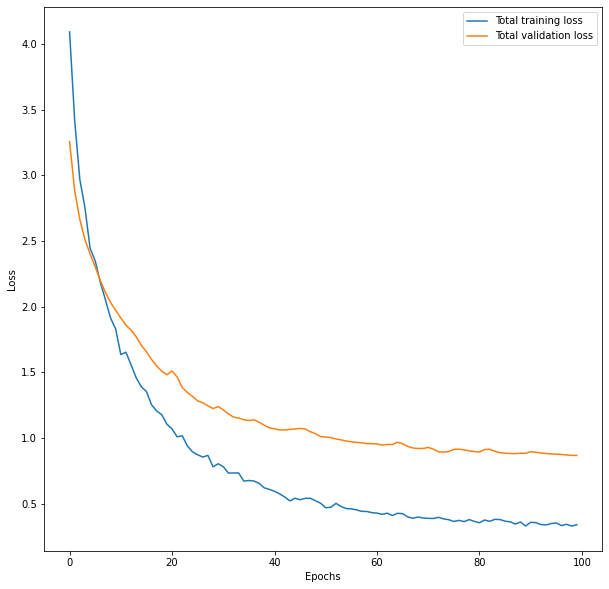

In [21]:
plt.figure(figsize=(10, 10))

plt.plot(history_vgg16.history['loss'], label='Total training loss')
plt.plot(history_vgg16.history['val_loss'], label='Total validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

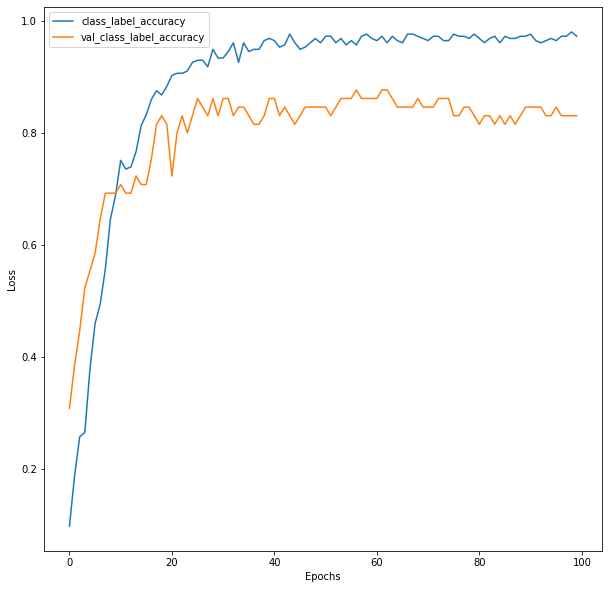

In [22]:
plt.figure(figsize=(10, 10))

plt.plot(history_vgg16.history['class_label_accuracy'], label='class_label_accuracy')
plt.plot(history_vgg16.history['val_class_label_accuracy'], label='val_class_label_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<p>Prediction using VGG16 and MobilNetV2</p>

In [33]:
def modelPrediction(imageName, modelName):
  print(modelName)
  print(imageName)
  image = load_img(imageName, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  (categoryPrediction,boxPrediction ) = modelName.predict(image)
  (xCoord, yCoord, width, height) = boxPrediction[0]
  print(xCoord, yCoord, width, height)

  image = cv2.imread(imageName)
  image = imutils.resize(image, width=600)

  imageHeight=image.shape[0]
  imageWidht=image.shape[1]

  xCoord = int(xCoord * imageWidht)
  yCoord = int(yCoord * imageHeight)
  width = int(width * imageWidht)
  height = int(height * imageHeight)
  print(xCoord, yCoord, width, height)

  label = labelsAndCategories[np.argmax(categoryPrediction)]

  if yCoord - 10 > 10:
    y = yCoord - 10  
  else:
    y = yCoord + 10

  cv2.putText(image, label, (xCoord, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
  cv2.rectangle(image, (xCoord, yCoord), (width, height), (0, 255, 0), 2)
  cv2_imshow(image)

In [24]:
testingPath = current_path+'/Dataset'
print(testingPath)

/content/drive/MyDrive/Yoga_Dataset/Dataset


/content/drive/MyDrive/Yoga_Dataset/Dataset/247.jpg
1/1 [==============================] - 0s 19ms/step
0.24752432 0.06167051 0.49899685 0.86556906
148 37 299 519


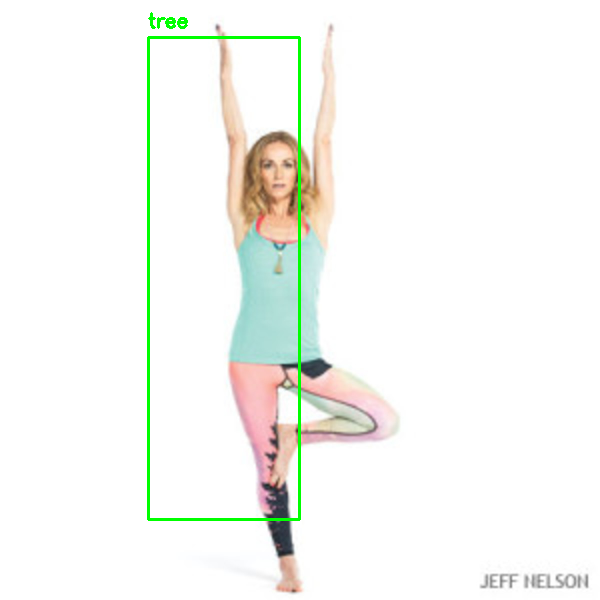

/content/drive/MyDrive/Yoga_Dataset/Dataset/247.jpg
1/1 [==============================] - 0s 24ms/step
0.2703332 0.033313952 0.5078267 0.9007601
162 19 304 540


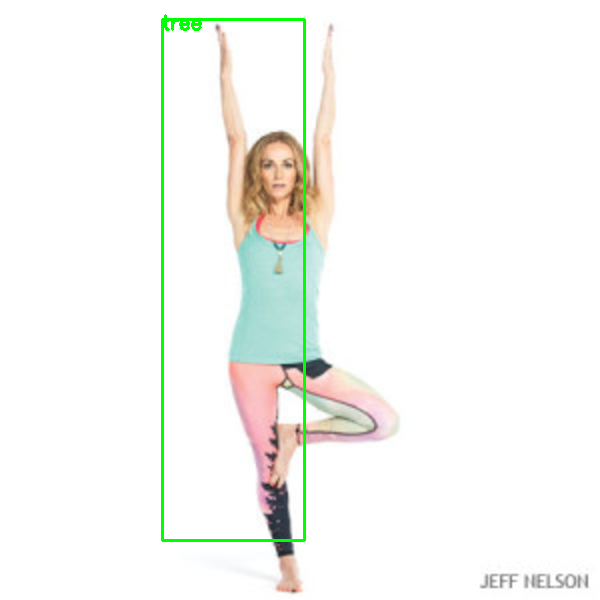

In [34]:
imageName = testingPath + '/247.jpg'
modelPrediction(imageName, vgg16)
modelPrediction(imageName, mobileNetV2)


/content/drive/MyDrive/Yoga_Dataset/Dataset/273.jpg
1/1 [==============================] - 0s 17ms/step
0.110043235 0.07623613 0.9340201 0.6630606
66 37 560 326


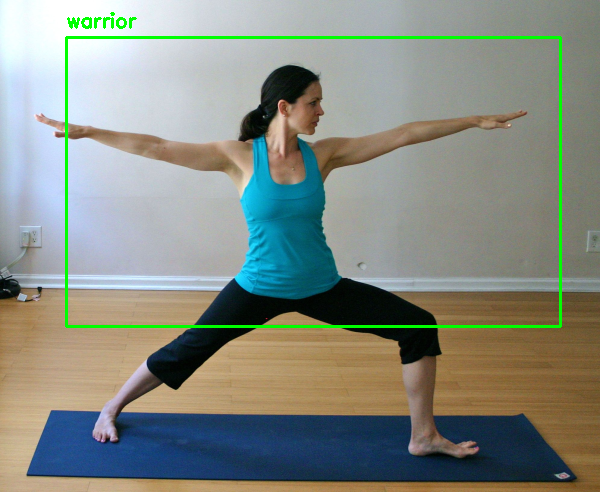

/content/drive/MyDrive/Yoga_Dataset/Dataset/273.jpg
1/1 [==============================] - 0s 31ms/step
0.04220515 0.11948465 0.9707482 0.64392555
25 58 582 316


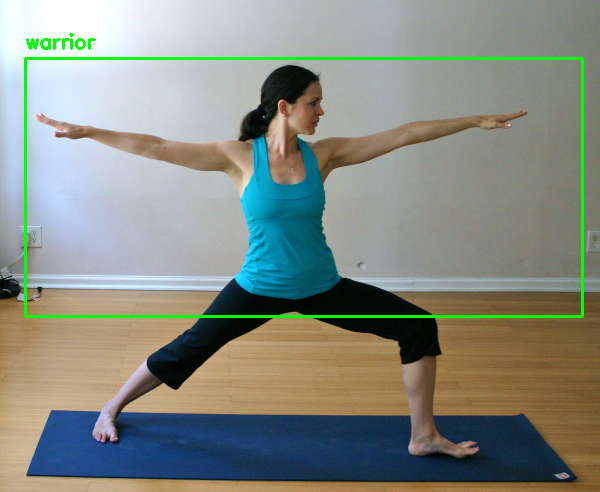

In [35]:
imageName = testingPath + '/273.jpg'
modelPrediction(imageName, vgg16)
modelPrediction(imageName, mobileNetV2)


/content/drive/MyDrive/Yoga_Dataset/Dataset/3.jpg
1/1 [==============================] - 0s 16ms/step
0.16640761 0.1813713 0.6698577 0.60727817
99 108 401 364


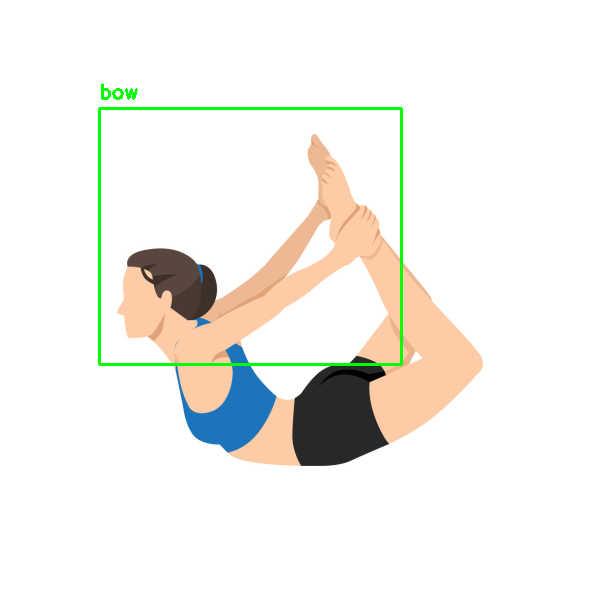

/content/drive/MyDrive/Yoga_Dataset/Dataset/3.jpg
1/1 [==============================] - 0s 20ms/step
0.17023842 0.20977205 0.6283629 0.61393917
102 125 377 368


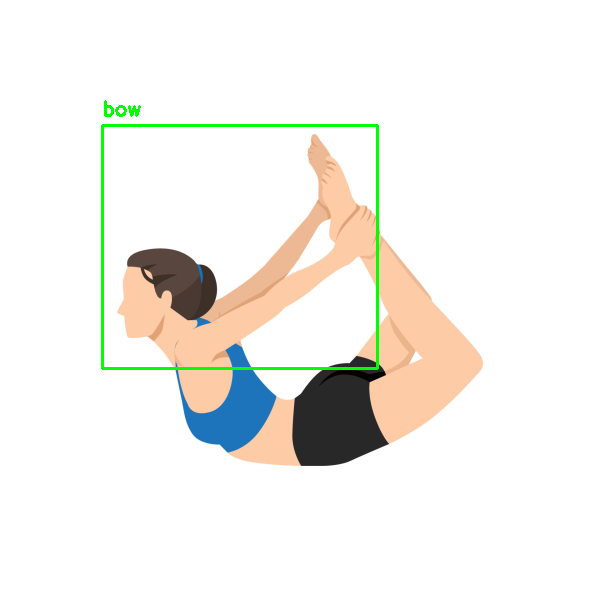

In [36]:
imageName = testingPath + '/3.jpg'
modelPrediction(imageName, vgg16)
modelPrediction(imageName, mobileNetV2)


/content/drive/MyDrive/Yoga_Dataset/Dataset/62.jpg
1/1 [==============================] - 0s 18ms/step
0.08166094 0.08497845 0.9823539 0.7388729
48 28 589 249


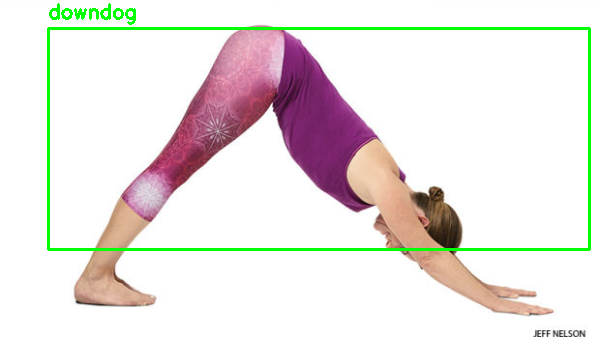

/content/drive/MyDrive/Yoga_Dataset/Dataset/62.jpg
1/1 [==============================] - 0s 19ms/step
0.026676966 0.13285233 0.99281585 0.69488764
16 44 595 234


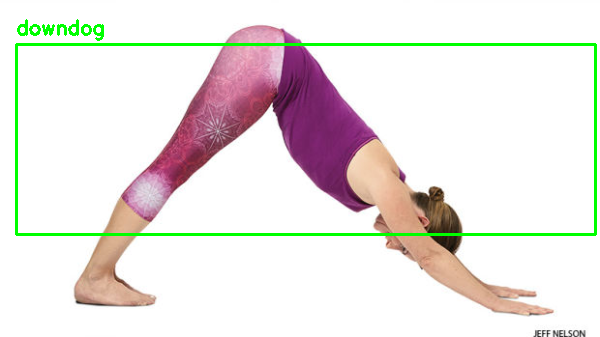

In [37]:
imageName = testingPath + '/62.jpg'
modelPrediction(imageName, vgg16)
modelPrediction(imageName, mobileNetV2)


/content/drive/MyDrive/Yoga_Dataset/Dataset/97.jpg
1/1 [==============================] - 0s 15ms/step
0.24513604 0.052529495 0.6269984 0.7202319
147 25 376 345


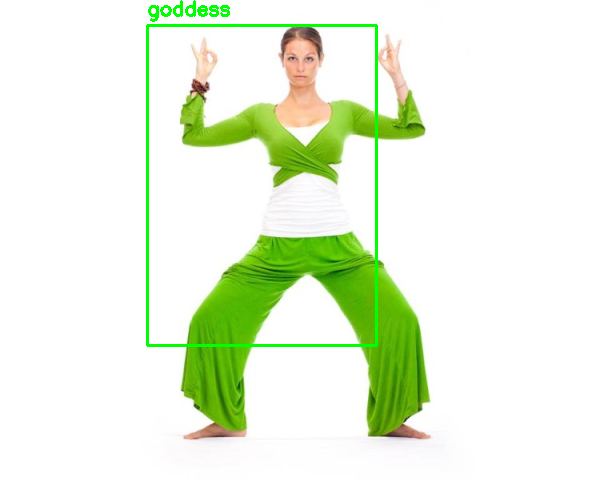

/content/drive/MyDrive/Yoga_Dataset/Dataset/97.jpg
1/1 [==============================] - 0s 23ms/step
0.24183823 0.020532606 0.60990775 0.7129768
145 9 365 342


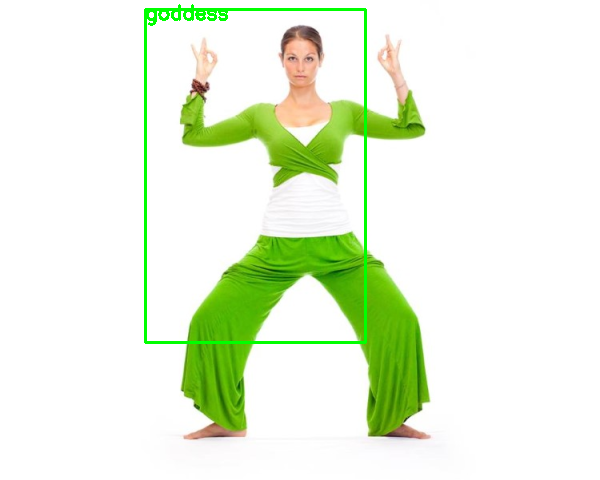

In [38]:
imageName = testingPath + '/97.jpg'
modelPrediction(imageName, vgg16)
modelPrediction(imageName, mobileNetV2)


In [39]:
print("Evaluation:")
print("After comparing the values of the result of evaluation, I can see that val_loss of VGG16 is less than that that of MobileNetV2.")
print("Similarly, VGG16 val_bounding_box_accuracy is better than MobileNetV2 val_bounding_box_accuracy ")
print("Hence, in this case VGG16 is performing better than MobileNetV2 ")

Evaluation:
After comparing the values of the result of evaluation, I can see that val_loss of VGG16 is less than that that of MobileNetV2.
Similarly, VGG16 val_bounding_box_accuracy is better than MobileNetV2 val_bounding_box_accuracy 
Hence, in this case VGG16 is performing better than MobileNetV2 
